In [9]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
import seaborn as sns
from copy import deepcopy
from jaxopt import ProjectedGradient

The first text cell

In [2]:
num_entrants = 100
num_winners_per_lottery = 7
num_lotteries = 30

rng = onp.random.default_rng(27)

winners = onp.zeros((num_entrants, num_lotteries))

for lottery in range(num_lotteries):
    winner_idx = rng.choice(num_entrants, size=num_winners_per_lottery, replace = False)
    winners[winner_idx, lottery] = 1

winners.shape


(100, 30)

/home/alex/anaconda3/envs/lottery/lib/python3.12/site-packages/plotnine/stats/stat_count.py:70: FutureWarning: The provided callable <function sum at 0x7ec41453e340> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


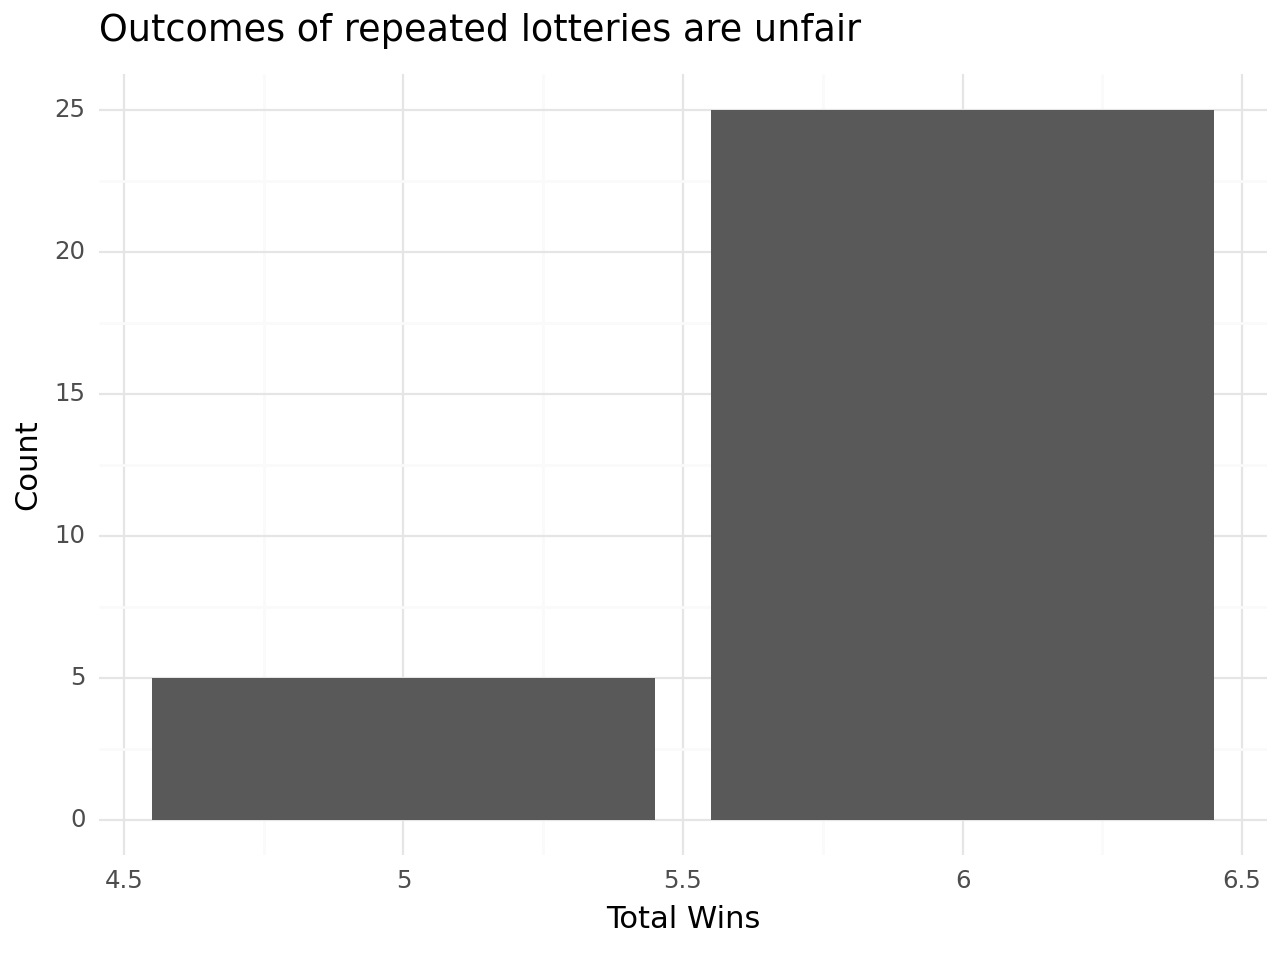

<Figure Size: (640 x 480)>

In [85]:
from plotnine import ggplot, aes, geom_bar, labs, theme_minimal

def plot_win_distribution(total_wins: onp.array):
    
    total_wins_df = pd.DataFrame(total_wins, columns=['total_wins'])
    
    plot =  (
        ggplot(total_wins_df) +
        aes(x='total_wins') +
        geom_bar() +
        labs(
            x='Total Wins',
            y='Count',
            title='Outcomes of repeated lotteries are unfair'
        ) +
        theme_minimal()
    )
    
    return plot

plot_win_distribution(winners.sum(axis = 1))

fairness is only really a problem when the number of seats is on approximately the same order of magnitude as the number of applicants -- if the marginal chance of winning is very small, repeated winners (and thus deviations from fairness) are going to be very unlikely regardless. similarly, if almost everyone gets in every time, repeated losers are going to very unlikely.

- "entitlement" to seats
- entered, won
- possibly scores


our goal: come up with an approach, such that, after t-1 lotteries have occured, we maximize the fairness of the $t^{th}$ lottery

goal to formulate this as a fairness objective and want to minimize unfairness. of course, many different ways you could define unfairness, we will pick one that seems reasonable and write it down

write down fairness objective
solution is a marginal probability of the winning the lottery at time t

how to sample according to this probability? a little tricky!
- going to assume the lottery has strict capactiy constraints
- idea 1 that doesn't work: if we do a coin flip for each entrant independently, there's no guarantee that we will admit the right number of people
- idea 2 that doesn't work: weighted sampling without replacement (cite reference): map between weights and marginal probability of selection is heinous
- solution: randomized pipage rounding (cite references)

what randomized pipage rounding does and why the literature is so hard to get into/to find this

In [22]:
def randomized_pipage_rounding(x):
    """
    Fast pipage rounding implementation for uniform matroid

    From https://github.com/bwilder0/clusternet
    See Randomized Pipage Rounding algorithm in http://arxiv.org/abs/1711.01566
    """
    i = 0
    j = 1
    x = onp.array(x)
    for _ in range(len(x) - 1):
        if x[i] == 0 and x[j] == 0:
            i = max((i, j)) + 1
        elif x[i] + x[j] < 1:
            if rng.random() < x[i] / (x[i] + x[j]):
                x[i] = x[i] + x[j]
                x[j] = 0
                j = max((i, j)) + 1
            else:
                x[j] = x[i] + x[j]
                x[i] = 0
                i = max((i, j)) + 1
        else:
            if rng.random() < (1 - x[j]) / (2 - x[i] - x[j]):
                x[j] = x[i] + x[j] - 1
                x[i] = 1
                i = max((i, j)) + 1

            else:
                x[i] = x[i] + x[j] - 1
                x[j] = 1
                j = max((i, j)) + 1
    return x

In [20]:

p = onp.array([0.1, 0.3, 0.4, 0.8, 0.4])

# confirm that p sums to an integer value
p.sum()

2.0

In [38]:
# quick confirmation the rounding() produces the correct marginals
reps = 1000
total = onp.zeros_like(p)
for i in range(reps):
    total += randomized_pipage_rounding(p)
total / reps - p

array([-0.013, -0.008,  0.01 ,  0.   ,  0.011])

In [39]:
def unfairness(prob_win, winners, num_winners_per_lottery):
    """
    TODO
    """

    # if jnp.any(prob_win < 0) or jnp.any(prob_win > 1):
    #     raise ValueError("Entries of `prob_win` must be contained in [0, 1]")

    # if num_winners_per_lottery != prob_win.sum():
    #     raise ValueError(f"`prob_win` ({prob_win.sum()}) must sum to the `num_winners_per_lottery` ({num_winners_per_lottery})")

    total_attendances = winners.sum(axis=1)
    num_entrants = winners.shape[0]
    lotteries_so_far = winners.shape[1]

    # fair_allocation_so_far = num_winners_per_lottery * lotteries_so_far / num_entrants
    # print(f"num slots per lottery {num_winners_per_lottery}, attendees per lottery: {num_entrants}, lotteries so far: {lotteries_so_far}, fair allocation so far = {fair_allocation_so_far}")

    # loss_so_far = jnp.max(jnp.abs(total_attendances - fair_allocation_so_far))
    expected_attendances = total_attendances + prob_win
    fair_allocation = num_winners_per_lottery * (lotteries_so_far + 1) / num_entrants

    # we get hit by jensen's inequality when computing this expected loss given prob_win
    # but i'm going to ignore that for now
    individual_deviations = expected_attendances - fair_allocation
    expected_loss = jnp.max(jnp.abs(individual_deviations))
    return expected_loss

In [66]:
pi_test = jnp.array([0.6, 0.4, 0.5, 0.1, 0.01, 0.89, 0.5])
num_winners_per_lottery = pi_test.sum()

winners = [randomized_pipage_rounding(pi_test) for _ in range(10)]
winners = jnp.column_stack(winners)

unfairness(pi_test, winners, num_winners_per_lottery=3)

Array(4.7042856, dtype=float32)

In [68]:
def projection_simplex_clip(r, simplex_sum=1):
    """
    Projects a real-valued vector onto the simplex, with the constraint the elements
    of the simplex sum to ``simplex_sum,`` and all entries of the vector must
    be between 0 and 1.

    Modified from http://www.ryanhmckenna.com/2019/10/projecting-onto-probability-simplex.html

    jaxopt.projection.projection_simplex(scale=num_winners_per_lottery) doesn't quite work for us
    because it allows potential attendees to be assigned marginal probabilities of attendance
    larger than one

    """
    lambdas = jnp.append(-r, 1 - r)
    idx = jnp.argsort(lambdas)
    lambdas = lambdas[idx]
    active = jnp.cumsum((idx < r.size) * 2 - 1)[:-1]
    diffs = jnp.diff(lambdas, n=1)
    totals = jnp.cumsum(active * diffs)
    # i = jnp.searchsorted(totals, 1.0)
    # lam = (1 - totals[i]) / active[i] + lambdas[i+1]
    i = jnp.searchsorted(totals, simplex_sum)
    lam = (simplex_sum - totals[i]) / active[i] + lambdas[i + 1]
    # NOTE: i added some additional renormalization here
    p = jnp.clip(r + lam, 0, 1)
    return p / p.sum() * simplex_sum

In [70]:
num_winners_per_lottery = 3

pg = ProjectedGradient(fun=unfairness, projection=projection_simplex_clip)
pg_sol = pg.run(
    init_params=pi_test,
    hyperparams_proj=num_winners_per_lottery,
    winners=winners,
    num_winners_per_lottery=num_winners_per_lottery,
)
pg_sol.params

Array([0.5576843 , 0.35768393, 0.45768398, 0.10768418, 0.99999994,
       0.06157982, 0.45768398], dtype=float32)

In [73]:
def lottery(p):
    return onp.round(randomized_pipage_rounding(p))

lottery(pg_sol.params)

array([1., 0., 1., 0., 1., 0., 0.], dtype=float32)

# Skip to here to see simulation results


In [75]:
# simulation to investigate properties of procedure

num_lotteries = 25
num_winners_per_lottery = 7
num_entrants = 30

win_expectation = onp.zeros((num_entrants, num_lotteries))
winners = onp.zeros_like(win_expectation)

win_expectation_equal = onp.ones(num_entrants) * num_winners_per_lottery / num_entrants

win_expectation[:, 0] = win_expectation_equal

pg = ProjectedGradient(fun=unfairness, projection=projection_simplex_clip)

for lottery in range(num_lotteries):

    # run the lottery
    winners[:, lottery] = onp.round(
        randomized_pipage_rounding(win_expectation[:, lottery])
    )

    # determine fair probabilities for next lottery
    next_win_expectations = pg.run(
        init_params=win_expectation_equal,
        hyperparams_proj=num_winners_per_lottery,
        winners=winners,
        num_winners_per_lottery=num_winners_per_lottery,
    )

    is_last_lottery = lottery == num_lotteries - 1
    if not is_last_lottery:
        win_expectation[:, lottery + 1] = onp.array(next_win_expectations.params)

In [76]:
# attendances per lottery, should be num_winners_per_lottery every time
winners.sum(axis=0)

array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7.])

In [87]:
# attendance per attendee. should be fairly even across attendees
winners.sum(axis=1)

array([6., 6., 6., 6., 6., 5., 6., 6., 5., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 5., 6., 6., 5., 6., 6., 6., 6., 6., 6., 6., 5.])

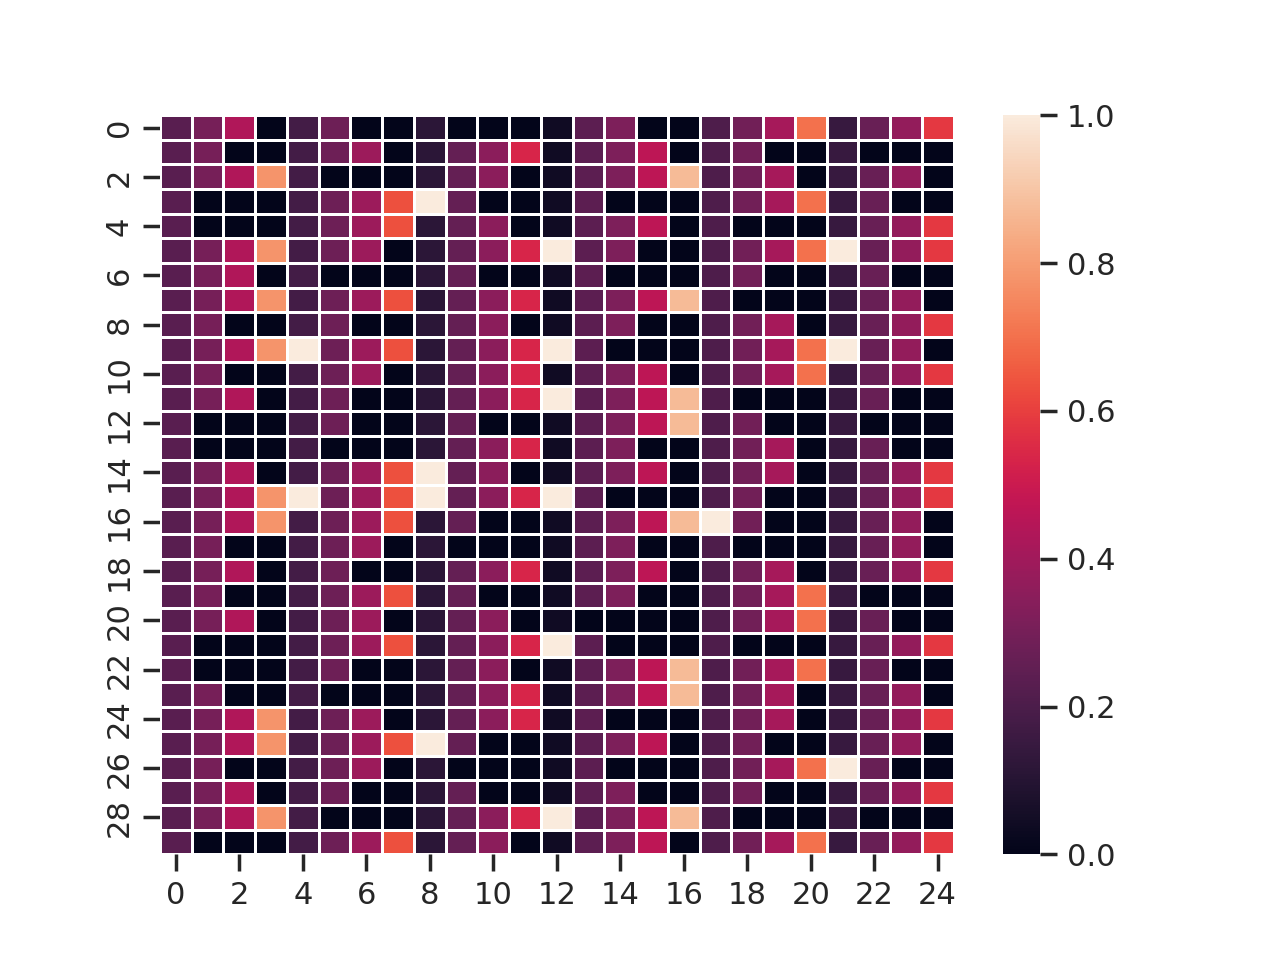

In [88]:
sns.heatmap(win_expectation, linewidth=0.5)
plt.show()

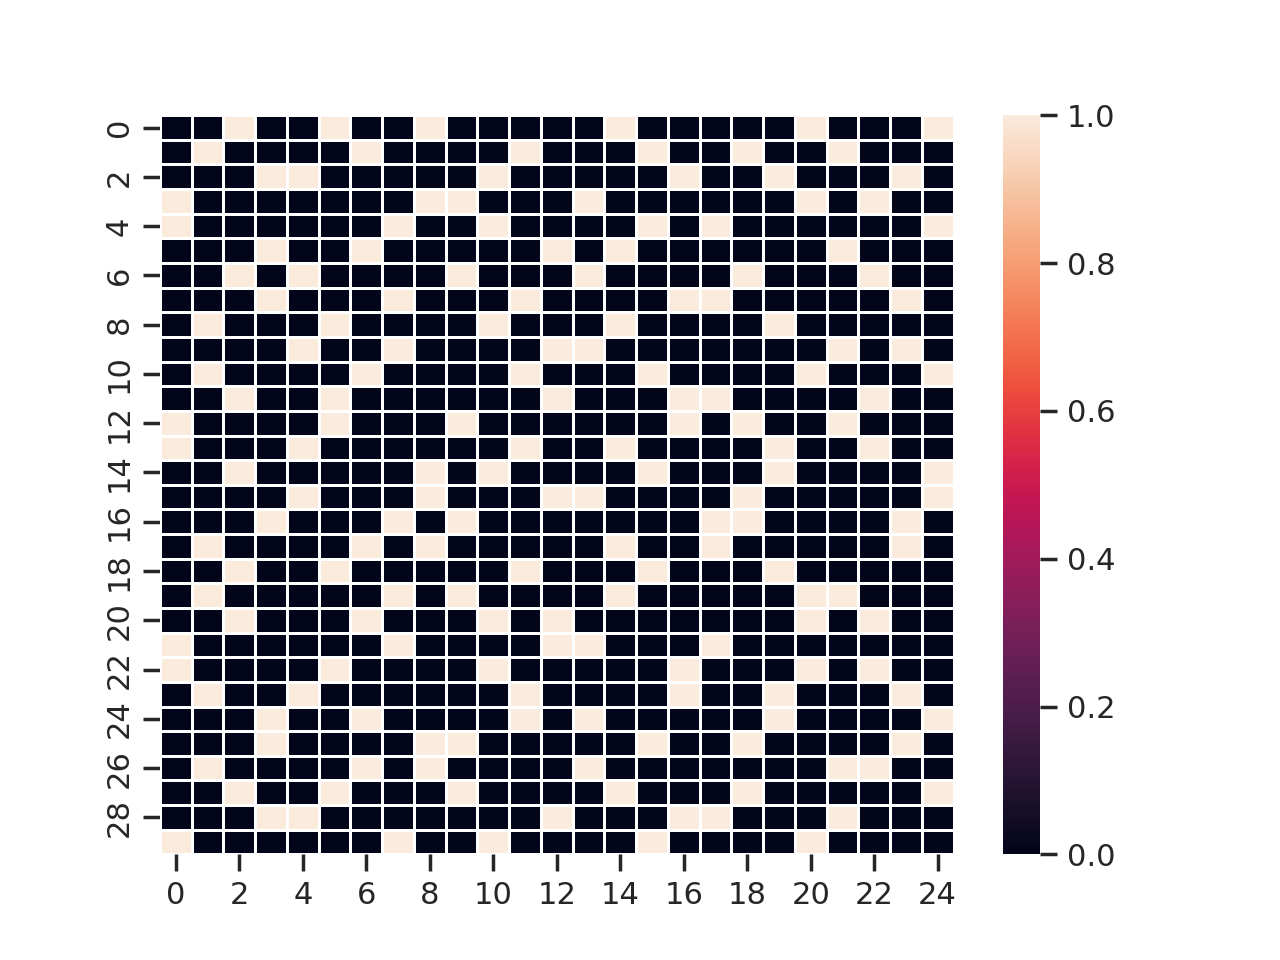

In [90]:
sns.heatmap(data=winners, linewidth=0.5)
plt.show()

some notes on this first solution. 

(1) this is just taking turns until everyone has had the thing once, and then letting people win a second time only after people have one the first time. in each lottery, pick randomly amongst people who haven't won yet. taking turns is a reasonable heuristic approach. 

taking turns breaks down if the number of winners each round is changing (event with changing capacity), if entrants are only applying to some lotteries but not all lotteries, if you think different people should have be assigned a different portion of the seats in an ideal case

In [107]:
import logging

class LotteryPool:
    """
    win_probability: 2d float array of marginal win probabilities (num_entrants x num_lotteries)
    winners: 2d binary array of winners (num_entrants x num_lotteries)
    scores: 2d float array of application scores (positive values only) (num_entrants x num_lotteries)
    lottery_size: 1d integer vector of number of winners per lottery (num_lotteries)    
    note that both num_entrants and num_lotteries are changing over time
    """
    
    def __init__(self, pool_name : str):
        
        self.pool_name = pool_name
        
        self.scores = None
        self.lottery_sizes = []
        self.win_probabilities = None
        self.winners = None
        
        self.pg = ProjectedGradient(fun=unfairness, projection=projection_simplex_clip)
    
    def entrant_sitrep(self, entrant_index : int):
        # print pool name
        # entries, portions of slots allocated by lottery, deviation from this, relative position (and rank) relative to the rest of entrants
        pass
    
    def run_lottery(self, scores, lottery_size: int):
        
        num_entrants = len(scores)
        
        # first lottery
        if self.scores is None:
            self.scores = scores.reshape(-1, 1)
            self.win_probabilities = onp.zeros_like(self.scores)
            self.winners = onp.zeros_like(self.scores)
        # repeated lottery
        else:

            num_pool_members = self.scores.shape[0]
            
            if num_entrants < num_pool_members:
                raise ValueError(
                    f"""
                    Must provide a score for each member of the pool. There are {num_pool_members}
                    pool members, but you only provided scores for {num_entrants} entrants.
                    """
                    )
                
            elif num_entrants > num_pool_members:
                num_new_entrants = num_entrants - num_pool_members
                num_lotteries = self.scores.shape[1]
                logging.warning(f"Adding {num_new_entrants} new pool members and retroactively setting past scores to zero for {num_lotteries} lotteries")
                retroactive_scores = onp.zeros((num_new_entrants, num_lotteries))
                self.scores = onp.vstack((self.scores, retroactive_scores))
        
        self.lottery_sizes.append(lottery_size)
        
        if lottery_size < 0:
            raise ValueError(f"Lottery must have positive number of winners, rather than {lottery_size} winners")
        elif num_entrants <= lottery_size:
            logging.warning(f"Everyone wins! Lottery allows {lottery_size} winners and there are only {num_entrants} entrants")
            current_fair_probabilities = onp.ones_like(scores)
            current_winners = onp.ones_like(scores)
        else:
            opt_results = pg.run(
                init_params=scores,
                hyperparams_proj=lottery_size,
                pool=self,
                lottery_size=lottery_size,
            )
            
            current_fair_probabilities = onp.array(opt_results.params)
            current_winners = onp.round(randomized_pipage_rounding(current_fair_probabilities))
        
        self.win_probability = onp.hstack((self.win_probabilities, current_fair_probabilities.reshape(-1, 1)))
        self.winners = onp.hstack((self.winners, current_winners.reshape(-1, 1)))        
        return current_winners

In [ ]:
def unfairness(current_win_probability, pool : LotteryPool, lottery_size):
    
    cwp_onp = onp.asarray(current_win_probability)

    if onp.any(cwp_onp < 0) or onp.any(cwp_onp > 1):
        raise ValueError("Entries of `current_win_probability` must be contained in [0, 1]")

    if lottery_size != cwp_onp.sum():
        raise ValueError(f"`current_win_probability` sums to {cwp_onp.sum()} but must sum to `lottery_size` instead, which is ({lottery_size})")
    
    lottery_sizes = onp.array(pool.lottery_sizes)
    scores_normed = pool.scores / pool.sum(axis = 0)
    allocation = scores_normed @ lottery_sizes + current_win_probability
    received = pool.winners.sum(axis=0)
    
    individual_deviations = received - allocation
    expected_loss = jnp.max(jnp.abs(individual_deviations))
    return expected_loss

In [110]:
demo_pool = LotteryPool("Demostration Pool")
pool = demo_pool

In [109]:

scores = rng.poisson(5, 20)
demo_pool.run_lottery(scores, lottery_size=13)

OverflowError: cannot convert float infinity to integer

ways this can break:

- if someone can apply multiple times without you realizing they are the same person, people are incentivized to just apply as many times as possible to get a slot
- if you need quotas to get a representative sample - Bailey says this should be a reasonably doable extension of her current work
- if people want to go in the future, but not now, they are motivated in the current lottery


extensions:
- waitlists: if people don't show up, count it as if they still attended
- buddies: coordinated with buddies or partner (fancy dinner for example)

who should consider implementing:
- people with sign up systems that are currently causing frustration about unfairness
- if you can id folks carefully: might help with scalping/people buying things with bots and then reselling at a much higher price
- if you have rapidly changing groups of entrants, will this feel "fair"? i don't know

- small communities make unequal distribution of resources feel less fair / when you know what other people got
- cognitive bias: "would have got in if not for the lottery"

fairness ideas: do we want to get everyone's expected number of times chosen as close as possible to the ideal, or instead everyone's *actual number of times chosen*



- Wanting to go to events with regulars so you can become a regular and have community
- Also, at the same time, wanting to go to events with new folks and to experience social variety and novelty
- Lotteries that allow ticket resale, which seems to be a fairly functional system? I'm also intrigued by FIFO ticket queues for some tickets and a lottery on the side, to potentially alleviate the "I would have been able to get a ticket if not for the lottery" feeling
- How critical it is to go to some events with buddies
- How lotteries feel bad even in comparison to first come first serve tickets because they feel less agentic
    - I proposed limited use "boosts" as one potential way around this, that pump your probability of attendance

There is potentially some interesting extension work to consider around buddies? As an extreme motivating case: suppose the current fair choice is for person A to attend with probability 1 and person B to attend with probability 0.
- What should the probability of the pair AB attending be, if you restrict admissions so that A and B either attend together or not at all. If you stick with individual level fairness, then AB will not attend, which I'm not sure is optimal! If you allow person B to be upweighted in this case, there's maybe an interesting dynamic to explore that encourages person B to find new people to bring to an event, which is an interesting design choice!
- Implementation-wise: is it easy to extend pipage rounding to the case where, for each x[i] in [0, k[i]], k[i] is a positive integer, not necessarily equal to one?

how i would hope to see this implemented at eventbrite, at marathons, etc

replace "first come, first served" time sales that become a race to click as fast as possible (who knows if businesses actually care about the customer experience here? selling out as fast as possible is probably good for them?)